# Classification with PyTorch

Author: Alejandro Meza

Examples of classification problems:
- Binary classification (dogs vs cats)
- Multi-class classification (sushi, pizza, hamburger)
- Multilabel classification

Some useful source: **imagenet**

## Input and Outputs

Some typical architecture is the following: inputs --> model --> output.

- Inputs: numerical representation (tensor,numpy array)
- Model: ML model
- Outputs: predictions probabilities (number of values == number of classes)

**From shape perspective**

224x244x3 (height,width,colorChannels)--> Inputs --> model --> Outputs --> [probClass1,...,probClassN]

When we process the data, we use some batches. **Recommended batch size:32**. So, putting all together, we have something like:

(32,3,224,224) --> rest of the representation ...



## Architecture of a classification model

**About the Hyperparameters**


*   Input layer shape --> [binary Classification: 5, mutliclass: same]
*   Hidden layer  --> [binary Classification: 1,unlimited, mutliclass: same]
*   Nuerons per layer   --> [binary Classification: 10 to 512,unlimited, mutliclass: same]
*   Outputs layer shape  --> [binary Classification: 1, mutliclass: number of classes]
*   Hidden layer activation --> [binary Classification: RELU, mutliclass: same]
*   Output activation  --> [binary Classification: sigmoid, mutliclass: softmax]
*   Loss function --> [binary Classification: binary cross entropy, mutliclass: cross entropy]
*   Optimizer --> [binary Classification: SGD, Adam , mutliclass: same]

## 1. Make classification data and get it ready

In [ ]:
import sklearn
from sklearn.datasets import make_circles

n_samples = 1000
X, y =  make_circles(n_samples,
                     noise=0.03,
                     random_state=42)

In [ ]:
X[:5],y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [ ]:
#Make a dataframe with pandas about the data
import pandas as pd
circles = pd.DataFrame({"X1":X[:,0],"X2":X[:,1],"label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


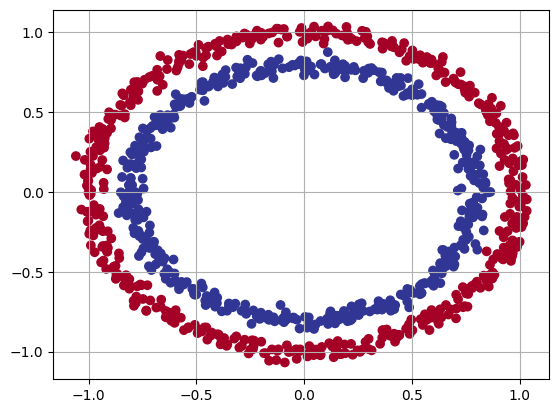

In [ ]:
# Visualize the results
import matplotlib.pyplot as plt
plt.scatter(X[:,0],
            X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.grid()

**Toy dataset**: a dataset that is small enoguh to experiment but still sizeable enough to practice the fundamentals.

##1.2 Create a proper dataset

In [ ]:
#check the input and output shapes
X.shape,y.shape
print(type(X),type(y))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
import torch
torch.__version__

'2.4.0+cpu'

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [ ]:
#Split the data in train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.3)

In [ ]:
#the number of total samples that we have: 1000
len(X_train),len(X_test)

(700, 300)

## 2.Build a model

Let's build a model to classify our points in red/blue.

To do so, we want the following:
1. Set up device diagnose code to run the code on GPU
2. Construct model (subclass nn module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [ ]:
##1.Set up device
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
X_train

tensor([[-0.9342, -0.2457],
        [-0.9256,  0.3373],
        [ 0.9073,  0.1618],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

##2.Construct model

1. Subclass nn.module
2. Create 2 nn.Linear() layers that are capable of handling the shapes of our data
3. Defines a forward() method that outilines the forward pass (or forward computation)
4. Instantiate an instance of our model class and send to the target device


In [ ]:
X_train.shape

torch.Size([700, 2])

In [ ]:
##1.Construct model that subclass for nn.module
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    ##2. Create 2 nn linear layers that are capablew of handling the shapes of our data
    ## the layers have to match --> THIS CASE: 2->6->1 --> only 1 hidden layer
    self.layer_1 = nn.Linear(in_features=2,out_features=6) #upscale from 2 to 6 feautures
    self.layer_2 = nn.Linear(in_features=6,out_features=1)

  ##3. Defines a forward() method that outilines the forward pass (or forward computation)
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) #x-->layer 1--> layer2

##4. Instantiate an instance of our model class and send to the target device
model_0 = CircleModel()
model_0.to(device)
model_0

CircleModel(
  (layer_1): Linear(in_features=2, out_features=6, bias=True)
  (layer_2): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
next(model_0.parameters()).device #code to check where the model is located

device(type='cpu')

**How to check this visually**: you can use tensorflow visualization tool - tensorflow playground - to check the results.  

But, how about using something to be able to build the model in an easier way? That's the role of **torch.sequential** !!

Basically, it implements functionalities that are described in the code above, but in an easier way: linear functions definitions, forward method, init method ...



In [ ]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=6), #first layer
    nn.Linear(in_features=6,out_features=1) #second layer
).to(device)

In [ ]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=6, bias=True)
  (1): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
##1.Construct model that subclass for nn.module
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features=2,out_features=6), #upscale from 2 to 6 feautures
        nn.Linear(in_features=6,out_features=1)
    )

  ##3. Defines a forward() method that outilines the forward pass (or forward computation)
  def forward(self,x):
    return self.two_linear_layers(x) #x-->layer 1--> layer2

##4. Instantiate an instance of our model class and send to the target device
model_0 = CircleModel()
model_0.to(device)
model_0

CircleModel(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): Linear(in_features=6, out_features=1, bias=True)
  )
)

So, we have at least two ways of creating models in Pytorch:

- Sequential module
- Subclass from nn.module and create a proper class

In [ ]:
#check the parameters values
model_0.state_dict()

OrderedDict([('two_linear_layers.0.weight',
              tensor([[-0.3877, -0.1202],
                      [-0.6928,  0.3454],
                      [ 0.0843, -0.2765],
                      [ 0.6203, -0.1227],
                      [ 0.5453,  0.1018],
                      [ 0.2429,  0.5611]])),
             ('two_linear_layers.0.bias',
              tensor([ 0.1058,  0.4834, -0.3188,  0.5725, -0.6468, -0.3853])),
             ('two_linear_layers.1.weight',
              tensor([[-0.0147, -0.3829,  0.3201,  0.0829, -0.1808, -0.0909]])),
             ('two_linear_layers.1.bias', tensor([-0.2730]))])

**Explanation**:

- First layer: for each sample, we have 2 different weights.
- Second layer: for each node, we have 1  weight.

In [ ]:
#Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f'Lenght of predictions: {len(untrained_preds)},\nShape: {untrained_preds.shape}')
print(f'First 10 predictions: {untrained_preds[:10]}')
print(f'First 10 labels: {y_test[:10]}')

Lenght of predictions: 300,
Shape: torch.Size([300, 1])
First 10 predictions: tensor([[-0.6520],
        [-0.6454],
        [-0.4291],
        [-0.7161],
        [-0.0481],
        [-0.0471],
        [-0.3307],
        [-0.1896],
        [-0.4455],
        [-0.6408]])
First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


**Notice**

We can notice that the output is not the thing that we need. Thta's why we are facing a classification problem.

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should be good for a classification problem??


**LOSS FUNCTION**

- Regression: you're predicting a number --> MAE/MSE
- Classification: binary cross entropy / categorical cross entropy

As a reminder, loss function measures how wrong your model is.

And for optimizers, two of the most common and useful are SDG and Adam, however Pytorch has many built-in options.

* For the loss function we are going to use 'torch.nn.BECWithLogitLoss()'

* For optimizers, we are going to use torch.optim.

**What is logit?**

In deep learning, especially in the context of binary classification tasks, the term "logit" typically refers to the raw (non-normalized) output of a logistic regression model or a neural network before applying the logistic sigmoid function.

In the context of neural networks, especially in the output layer for binary classification, the logit Z refers to the pre-activation value of the output neuron(s) before applying the activation function (typically the logistic sigmoid for binary classification or softmax for multiclass classification).




In [ ]:
loss_fn = nn.BCEWithLogitsLoss() #contains sigmoid function --> better than BCELoss(sigmoid) --> that version is less stable than the predefined version

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
#Calculate accuracy --> (TP/(TP+TN)) * 100
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

##3.Train the model

To train our model, its necessary to use the training loop.

0. Define the number of epochs  
1. Forward
2. Loss
3. Optimizer zero grad
4. Loss backward
5. Optimizer step --> gradient descent

### 3.1 Going from raw logits --> prediction probs --> labels

Our model's outputs are going to be **logits**.

We can convert this **logits** into prediction probabilities, if we pass them to some kind of activation function (softmax, binary crossentropy).

Then, we can convert our model predictions probalities into labels, by either rounding them or taking the argmax().

In [ ]:
#View the first 5 outputs of the forward pass
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_train.to(device))[:5]
y_logits

tensor([[-0.5026],
        [-0.6747],
        [-0.2031],
        [-0.0697],
        [-0.5378]])

So, it is **necessary to apply the activation function**.

In [ ]:
#Use the sigmoid function over the logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3769],
        [0.3374],
        [0.4494],
        [0.4826],
        [0.3687]])

For our prediction probability values, we need to perform a range-style rounding on them:

* Y_pred_probs >= 0.5 --> 1    Class 1
* Else: ---> 0                 Class 0



In [ ]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [ ]:
#Make a prediction with the model, and obtain the proper label with torch.round()
y_pred_probs_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))
y_pred_probs_labels = y_pred_probs_labels.squeeze()
print(y_pred_probs_labels[:5])

tensor([0., 0., 0., 0., 0.], grad_fn=<SliceBackward0>)


### 3.2 Building a training loop

It's time to build our training loop!

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
model_0 = CircleModel()
model_0.to(device)

loss_fn = nn.BCEWithLogitsLoss() #contains sigmoid function --> better than BCELoss(sigmoid) --> that version is less stable than the predefined version

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [ ]:
#Calculate accuracy --> (TP/(TP+TN)) * 100
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [ ]:
torch.cuda.manual_seed(42)

epochs = 100

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):

  ### Training
  model_0.train()

  ###1.Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  ###2.Calculate the loss
  loss = loss_fn(y_logits,y_train) #loss_fn --> BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  ###3.Optimizer zero grad
  optimizer.zero_grad()

  ###4.Loss backward
  loss.backward()

  ###5.Optimizer step
  optimizer.step()

  ### Testing
  model_0.eval() #to prevent update the gradient values
  with torch.inference_mode():
    #1. Forward passs
    test_logits = model_0(X_test).squeeze()

    #2.Test preds
    test_pred = torch.round(torch.sigmoid(test_logits))

    #3.Calculate the accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    #print out what's happening
    if epoch % 10 ==0:
      print(f"Epoch: {epoch} ----- Loss: {loss} ------ Train acc: {acc} ----- Test loss: {test_loss} ---- Test Acc: {test_acc}")


Epoch: 0 ----- Loss: 0.7190636992454529 ------ Train acc: 49.142857142857146 ----- Test loss: 0.7043046355247498 ---- Test Acc: 52.0
Epoch: 10 ----- Loss: 0.699885368347168 ------ Train acc: 49.142857142857146 ----- Test loss: 0.6933664083480835 ---- Test Acc: 52.0
Epoch: 20 ----- Loss: 0.6951315402984619 ------ Train acc: 49.142857142857146 ----- Test loss: 0.6920032501220703 ---- Test Acc: 50.0
Epoch: 30 ----- Loss: 0.6938924789428711 ------ Train acc: 46.714285714285715 ----- Test loss: 0.6923452019691467 ---- Test Acc: 51.0
Epoch: 40 ----- Loss: 0.6935054063796997 ------ Train acc: 49.714285714285715 ----- Test loss: 0.6927925944328308 ---- Test Acc: 50.66666666666667
Epoch: 50 ----- Loss: 0.6933349370956421 ------ Train acc: 51.714285714285715 ----- Test loss: 0.693120002746582 ---- Test Acc: 51.33333333333333
Epoch: 60 ----- Loss: 0.6932291984558105 ------ Train acc: 52.85714285714286 ----- Test loss: 0.6933491826057434 ---- Test Acc: 54.0
Epoch: 70 ----- Loss: 0.6931501030921936

So, since the accuracy is around 50%, basically we are doing a head/tales approach. It's time to improve the results.

But first, let's take a look to the model performance by now.

##4. Make predictions with the model

From the metrics, it looks like the model is not learning anything. It's time to visualize the cause. For this, we are going to use an **external** function.

In [ ]:
import requests
from pathlib import Path

#Download the function to visualize the data if its not already downloaded
if Path("helper_functions.py").is_file():
  print('Skipping download')
else:
  print('Donwload helper_functions.py')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py','wb') as f:
    f.write(request.content)

#import functions from the helpful module
from helper_functions import plot_predictions, plot_decision_boundary

Donwload helper_functions.py


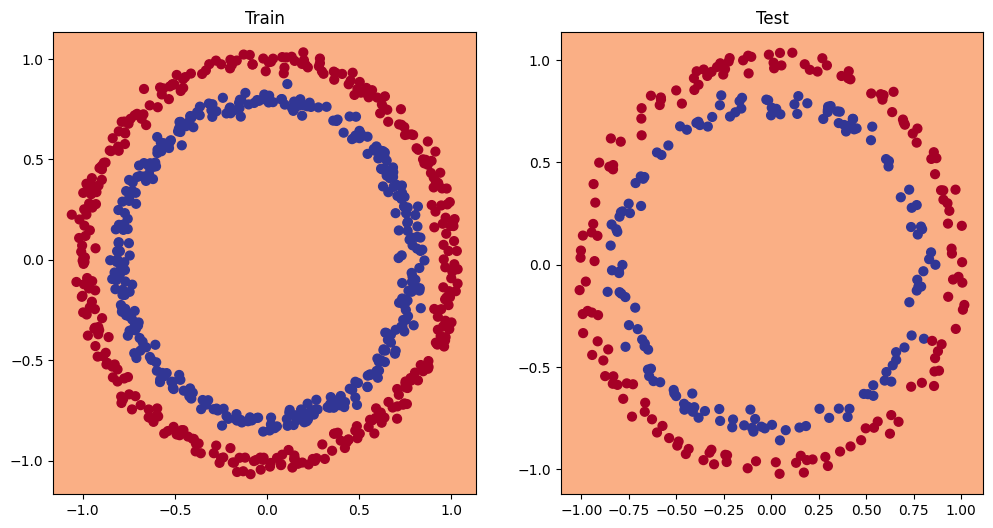

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0,X_test,y_test)

### 5.Improving the model

These options are model's perspective.

(**Hyperparameters**)
* Add more layers
* Add more hidden units -from 5 to  N-
* Fit for longer (increase epoch)
* Change the activation functions
* Change the learning rate
* Change the optimization method
* Change the loss function

Also, there are data approaches.

* Increase data
* Check the quality of the data
* Check the data distribution --> data inbalance

Let's try to:
* Adding more hidden units
* Increase the number of layers
* Increase the number of epochs

Since there are 3 things that you can change, let's try to make a change sequentially. In this way, we are going to find the problem easily. This is the meaning of **tracking**.

In [ ]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.0998,  0.1815],
                      [-0.5030, -0.2662],
                      [-0.5491, -0.4798],
                      [ 0.1157,  0.3264],
                      [-0.1975, -0.3777],
                      [ 0.0687,  0.6171],
                      [-0.3663, -0.2544],
                      [ 0.3536,  0.5722],
                      [-0.1069,  0.6362],
                      [ 0.0051,  0.4489]])),
             ('layer_1.bias',
              tensor([ 0.3471, -0.0265, -0.2913,  0.4373, -0.5942, -0.6359,  0.3504,  0.1605,
                       0.4889,  0.3385])),
             ('layer_2.weight',
              tensor([[-0.2129, -0.1754, -0.1803, -0.0324,  0.2047, -0.2065, -0.2137,  0.1321,
                       -0.2922, -0.3103],
                      [ 0.1970,  0.0615,  0.0440, -0.2484,  0.2836,  0.0946,  0.0508,  0.0023,
                       -0.1350, -0.1461],
                      [-0.0195,  0.1624, -0.2704, -0.1250, -0.2669, -0.1

In [ ]:
# Create a loss function
loss_fn  = nn.BCEWithLogitsLoss()

# Create an optimizer
optimzer = torch.optim.SGD(params=model_1.parameters(),
                           lr=0.1) #maybe the learning rate here should change

In [ ]:
#write a training loop
torch.manual_seed(42)

#Train for longer
epochs = 1000

#Put the data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## Training
  model_1.train()
  # 1.forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2. calculate the loss/accuracy
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3.optimizer zero grad
  optimizer.zero_grad()

  #4.loss backwards
  loss.backward() #perform back propagation

  #5.optimizer step
  optimizer.step()

  ##Testing
  model_1.eval()
  with torch.inference_mode():
    #1.forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2.Calculate the loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                        y_pred = test_pred)

    #3.Print out results
    if epoch%100==0:
      print(f'Epoch: {epoch} / train_loss: {loss} / train_acc: {acc} / test_loss: {test_loss} / test_acc: {test_acc}')

Epoch: 0 / train_loss: 0.7122094035148621 / train_acc: 50.857142857142854 / test_loss: 0.7247593402862549 / test_acc: 48.0
Epoch: 100 / train_loss: 0.7122094035148621 / train_acc: 50.857142857142854 / test_loss: 0.7247593402862549 / test_acc: 48.0
Epoch: 200 / train_loss: 0.7122094035148621 / train_acc: 50.857142857142854 / test_loss: 0.7247593402862549 / test_acc: 48.0
Epoch: 300 / train_loss: 0.7122094035148621 / train_acc: 50.857142857142854 / test_loss: 0.7247593402862549 / test_acc: 48.0
Epoch: 400 / train_loss: 0.7122094035148621 / train_acc: 50.857142857142854 / test_loss: 0.7247593402862549 / test_acc: 48.0
Epoch: 500 / train_loss: 0.7122094035148621 / train_acc: 50.857142857142854 / test_loss: 0.7247593402862549 / test_acc: 48.0
Epoch: 600 / train_loss: 0.7122094035148621 / train_acc: 50.857142857142854 / test_loss: 0.7247593402862549 / test_acc: 48.0
Epoch: 700 / train_loss: 0.7122094035148621 / train_acc: 50.857142857142854 / test_loss: 0.7247593402862549 / test_acc: 48.0
Ep

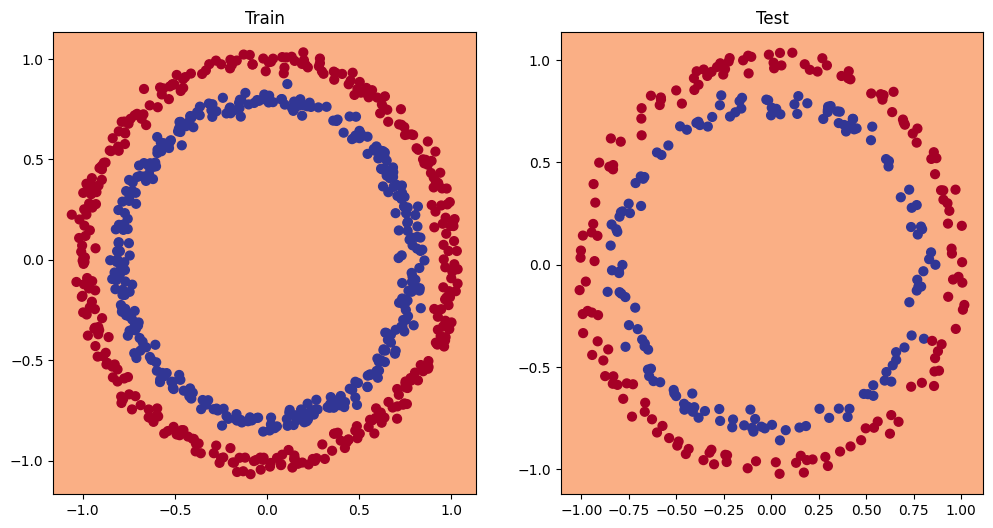

In [ ]:
#plot the decision boundary
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1,X_test,y_test)

So, we can see that our approach was not sufficient!! We are trying to separate the data using a linnear approach.


### 5.1 Preparing data to see if our model can fit a straight line

We are gonna create new data, to see if our model works or not.

In [ ]:
weight = 0.7
bias =0.3
start=0
end = 1
step = 0.01

#Create data
X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight*X_regression + bias

#check the data
print(X_regression[:5],y_regression[:5])

tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400]]) tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280]])


In [ ]:
#create train and test splits
train_split = int(0.8*len(X_regression))
X_train_regression, y_train_regression  = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

#check the lenghts
len(X_train_regression),len(y_train_regression),len(X_test_regression),len(y_test_regression)

(80, 80, 20, 20)

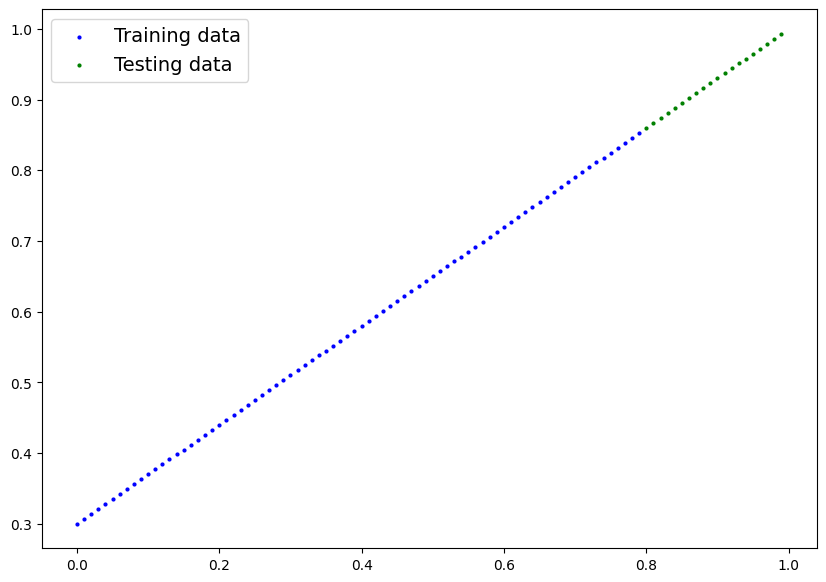

In [ ]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression)

In [ ]:
### 5.2 Adjusting the model 1 to fit the data

#in this case, we only have one input --> change the input layer

class model_2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=1,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_2 = model_2().to(device)
model_2

model_2(
  (layer_1): Linear(in_features=1, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [ ]:
# Loss and optimizer
loss_fn = nn.L1Loss() #since its a regression problem
optimizer = torch.optim.SGD(model_2.parameters(),
                            lr=0.001)

In [ ]:
#write a training loop
torch.manual_seed(42)

#Train for longer
epochs = 1000

#Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  ## Training
  model_2.train()
  # 1.forward X_train_regression
  y_pred = model_2(X_train_regression)

  #2. calculate the loss/accuracy
  loss = loss_fn(y_pred,y_train_regression)

  # 3.optimizer zero grad
  optimizer.zero_grad()

  #4.loss backwards
  loss.backward() #perform back propagation

  #5.optimizer step
  optimizer.step()

  ##Testing
  model_2.eval()
  with torch.inference_mode():
    #1.forward pass
    test_pred = model_2(X_test_regression)

    #2.Calculate the loss
    test_loss = loss_fn(test_pred,
                        y_test_regression)

    #3.Print out results
    if epoch%100==0:
      print(f'Epoch: {epoch} / train_loss: {loss} / test_loss: {test_loss}')

Epoch: 0 / train_loss: 0.7598584890365601 / test_loss: 0.9496515989303589
Epoch: 100 / train_loss: 0.4027175009250641 / test_loss: 0.5402894616127014
Epoch: 200 / train_loss: 0.05876145511865616 / test_loss: 0.1347997486591339
Epoch: 300 / train_loss: 0.014611688442528248 / test_loss: 0.03342229127883911
Epoch: 400 / train_loss: 0.0030826344154775143 / test_loss: 8.409023575950414e-05
Epoch: 500 / train_loss: 0.0030881264247000217 / test_loss: 0.00012148618407081813
Epoch: 600 / train_loss: 0.0030934219248592854 / test_loss: 0.00017864703841041774
Epoch: 700 / train_loss: 0.0029882509261369705 / test_loss: 0.00011395216279197484
Epoch: 800 / train_loss: 0.0029936223290860653 / test_loss: 0.00016087890253402293
Epoch: 900 / train_loss: 0.0028887875378131866 / test_loss: 0.0001111567034968175


So, our model was not bad! The reason was that we did not include any not linear layer.

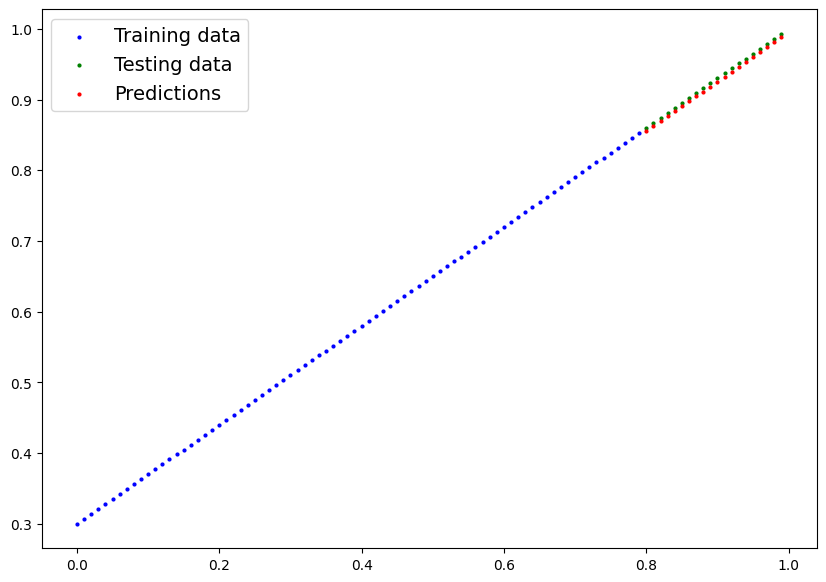

In [ ]:
model_2.eval()

with torch.inference_mode():
  y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression,
                 predictions=y_preds)

## 6. Missing piece: non-linearity

What patterns could you draw if you were given an infinite amount of a straight and non-straight lines?

Or in ML terms, an infinite (but really it is a finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue circles)

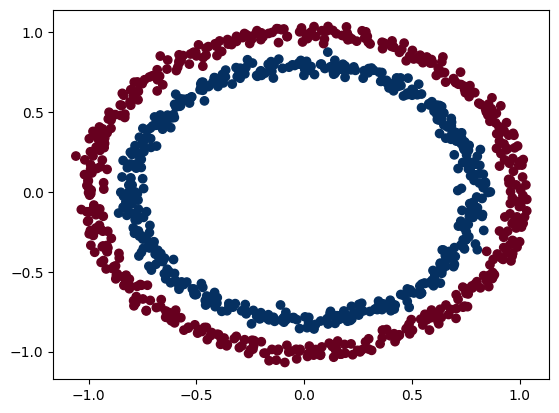

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

plt.scatter(X[:,0],X[:,1],c=y,cmap=plt.cm.RdBu)

In [ ]:
type(X)

numpy.ndarray

11:58:00

In [ ]:
#convert the data into tensors, and then perform train/test splits
import torch
from sklearn.model_selection import train_test_split

#turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train[:5],y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

So, it's the moment to search for a non-linear function!

### 6.2 Building a model with non-liniarity

* Linear = straight linear (sigmoid)
* Non linear = more complex shapes (reLU)

In [ ]:
# BUild a model with non-linear activation function --> more complex shapes
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2,out_features=1000)
    self.layer_2 = nn.Linear(in_features=1000,out_features=1000)
    self.layer_3 = nn.Linear(in_features=1000,out_features=1000)
    self.layer_4 = nn.Linear(in_features=1000,out_features=1000)
    self.layer_5 = nn.Linear(in_features=1000,out_features=1)
    #max(0,X)
    self.relu = nn.ReLU()

  def forward(self,x):
    #where should we put our non-linear function? --> between the outputs of the layers
    return  (self.layer_5(self.relu(self.layer_4(self.relu(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=1000, bias=True)
  (layer_2): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_3): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_4): Linear(in_features=1000, out_features=1000, bias=True)
  (layer_5): Linear(in_features=1000, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
# Create a loss function
loss_fn  = nn.BCEWithLogitsLoss()

# Create an optimizer
optimzer = torch.optim.SGD(params=model_3.parameters(),
                           lr=0.01) #maybe the learning rate here should change

In [ ]:
#model_3.state_dict()

In [ ]:
#write a training loop
torch.manual_seed(42)

#Train for longer
epochs = 1000

#Put the data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ## Training
  model_3.train()

  # 1.Forward pass
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) #logits-->prediction labels

  #2. calculate the loss/accuracy
  loss = loss_fn(y_logits,y_train) #takes in logits as first input
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  # 3.optimizer zero grad
  optimizer.zero_grad()

  #4.loss backwards
  loss.backward() #perform back propagation

  #5.optimizer step
  optimizer.step()

  ##Testing
  model_3.eval()
  with torch.inference_mode():
    #1.forward pass
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2.Calculate the loss
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                        y_pred = test_pred)

    #3.Print out results
    if epoch%100==0:
      print(f'Epoch: {epoch} / train_loss: {loss} / train_acc: {acc} / test_loss: {test_loss} / test_acc: {test_acc}')

Epoch: 0 / train_loss: 0.6931188702583313 / train_acc: 50.0 / test_loss: 0.6933556199073792 / test_acc: 50.0
Epoch: 100 / train_loss: 0.6931188702583313 / train_acc: 50.0 / test_loss: 0.6933556199073792 / test_acc: 50.0
Epoch: 200 / train_loss: 0.6931188702583313 / train_acc: 50.0 / test_loss: 0.6933556199073792 / test_acc: 50.0
Epoch: 300 / train_loss: 0.6931188702583313 / train_acc: 50.0 / test_loss: 0.6933556199073792 / test_acc: 50.0
Epoch: 400 / train_loss: 0.6931188702583313 / train_acc: 50.0 / test_loss: 0.6933556199073792 / test_acc: 50.0
Epoch: 500 / train_loss: 0.6931188702583313 / train_acc: 50.0 / test_loss: 0.6933556199073792 / test_acc: 50.0
Epoch: 600 / train_loss: 0.6931188702583313 / train_acc: 50.0 / test_loss: 0.6933556199073792 / test_acc: 50.0
Epoch: 700 / train_loss: 0.6931188702583313 / train_acc: 50.0 / test_loss: 0.6933556199073792 / test_acc: 50.0
Epoch: 800 / train_loss: 0.6931188702583313 / train_acc: 50.0 / test_loss: 0.6933556199073792 / test_acc: 50.0
Epo

## Evaluating our model trained with non-linear activation functions

In [ ]:
model_3.eval()
with  torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()

#compare predictions and real results
y_preds[:10],y_test[:10]

(tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

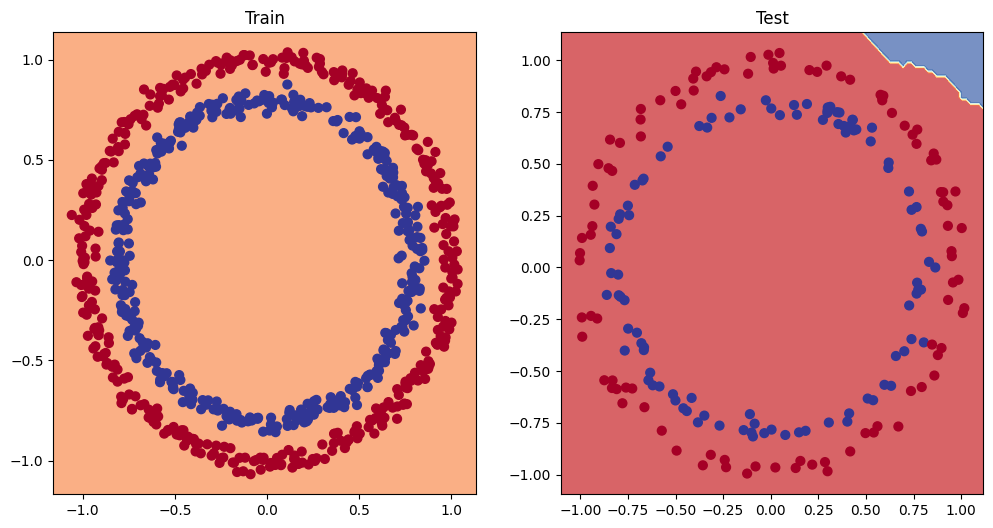

In [ ]:
#plot decission boundaries
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1,X_train,y_train)

plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_3,X_test,y_test)

So, at this point, you can try to improve the model with some of the following strategies:

- Use another activation function
- Change the learning rate
- Change the optimization method
- Increase the units/layer
- Increase the number of layers


## 8.Putting all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs dog, spam vs not spam)
* Multi-class classification = more than 2 different classes

### 8.1 Creating toy multi-class dataset

We are going to import a demo dataset to test our model.


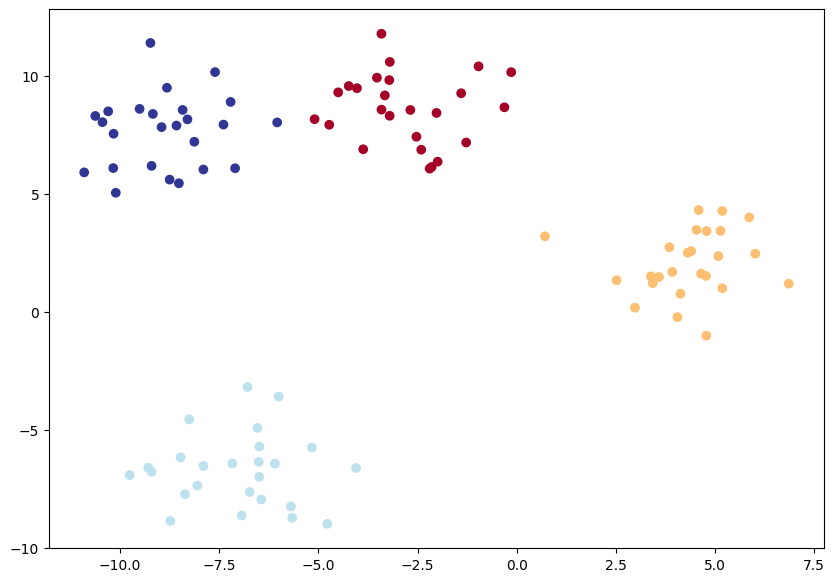

In [ ]:
#import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#set the parameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples = 100,
                            n_features = NUM_FEATURES,
                            centers = NUM_CLASSES,
                             cluster_std=1.5,
                            random_state = RANDOM_SEED
                            )

# 2. Turn data into tensors
#important to convert data to the appropiate float format
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

# 3. Split data into training and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)
# 4. Plot data (visualize the obtained data)
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0],X_blob[:,1],c=y_blob,cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model in Python


We need a non-linearity model to separate the data.

In [ ]:
#Create device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
#time to build a multi-class model
from torch import nn
class BlobModel(nn.Module):
  def __init__(self,input_features,output_features,hidden_units=8):
    '''
      Initialize multi-class classification model
      Args:
       - input features (int): number of input features of the model
       - Output features: number of classes
       -hidden units: number of hidden layers between layers

      Returns:

    '''
    super().__init__()

    #define the pass of elements between layers in a sequential way
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
print(next(model_4.parameters()).device)

cpu


In [ ]:
#In this case wont work, since we are not able to use GPU
model_4.to(device)

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

### 8.3 Create a loss function and optimizer

We are gonna try the loss funcion: **nn.CrossEntropyLoss**, because its useful when we are training a classification problem with C classes.

In [ ]:
# Create a loss function for multi-class classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting predictions probabilities for a multi-class pytorch model

In order to evaluate and train and test our model, we need to convert our model's outputs (logits) to prediction probabilities and then to prediction labels.

Logits --> pred_probs --> Pred labels

In [ ]:
model_4.eval()
with torch.inference_mode():
  y_preds = model_4(X_blob_test)

#basically, the ouput are probabilities for each class
y_preds[:10]

tensor([[ 0.0476, -1.5750, -0.1346, -0.9744],
        [ 0.3403, -0.8232,  0.4249, -0.8754],
        [ 0.4078, -0.4338,  0.2199, -0.1954],
        [ 0.3987, -0.9490,  0.4886, -1.0413],
        [ 0.5946, -1.1640,  0.1589, -0.6758],
        [ 0.4778, -0.4596,  0.1305, -0.2014],
        [-0.4197, -2.0351, -0.4099, -1.2982],
        [ 0.4320, -0.4178,  0.2102, -0.1734],
        [ 0.5526, -1.2655,  0.1206, -0.7428],
        [-0.2843, -1.6635, -0.0736, -1.3076]])

In [ ]:
#convert our model's logit outputs to prediction probabilities
#Basicially, in this case we obtain probabilities for each class (the max probability is 1 for one defined class)
y_pred_probs = torch.softmax(y_preds,dim=1)
y_pred_probs[:10]

tensor([[0.5308, 0.1911, 0.1916, 0.0865],
        [0.1566, 0.4548, 0.2766, 0.1121],
        [0.2904, 0.2455, 0.2977, 0.1664],
        [0.1367, 0.5098, 0.2654, 0.0881],
        [0.4653, 0.1978, 0.2119, 0.1251],
        [0.2943, 0.2383, 0.2885, 0.1789],
        [0.5970, 0.1803, 0.1676, 0.0551],
        [0.2849, 0.2485, 0.2997, 0.1669],
        [0.4841, 0.1953, 0.2030, 0.1176],
        [0.5295, 0.2241, 0.1937, 0.0527]])

In [ ]:
#let's obtain the max class for each sample and in this way, determined the class!
y_pred_probs = torch.argmax(y_pred_probs,dim=1)
y_pred_probs

tensor([0, 1, 2, 1, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 1, 2])

In [ ]:
#this are the test labels!
y_blob_test

tensor([3., 2., 1., 2., 0., 1., 3., 1., 0., 3., 3., 2., 0., 3., 1., 3., 2., 3.,
        2., 1.])

### 8.5 Create a training loop and testing loop for multi-class problem

In [ ]:
device = 'cpu'

In [ ]:
#Fit the multi-class model to the data
torch.manual_seed(42)

#set number of epochs
epochs = 100

#Put the data on the target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)

for epoch in range(epochs):
  ### TRAINING
  model_4.train()
  #1.forward pass
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)

  #2.calculate the loss
  loss = loss_fn(y_logits,y_blob_train.type(torch.LongTensor))
  acc = accuracy_fn(y_true=y_blob_train,y_pred=y_pred)

  #3.optimizer zero grad
  optimizer.zero_grad()

  #4.loss backwards
  loss.backward()

  #5.optimizer step
  optimizer.step()

  ### TESTING
  model_4.eval()
  with torch.inference_mode():

    #1.forward pass
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)

    #2.calculate the loss
    test_loss = loss_fn(test_logits, y_blob_test.type(torch.LongTensor))
    test_acc = accuracy_fn(y_true=y_blob_test,
                           y_pred=test_pred)

    #3.print out results
    if epoch%10==0:
      print(f'Epoch: {epoch} / train_loss: {loss} / train_acc: {acc} / test_loss: {test_loss} / test_acc: {test_acc}')

Epoch: 0 / train_loss: 1.3494747877120972 / train_acc: 52.5 / test_loss: 1.2145622968673706 / test_acc: 60.0
Epoch: 10 / train_loss: 0.6674370169639587 / train_acc: 75.0 / test_loss: 0.6151853799819946 / test_acc: 75.0
Epoch: 20 / train_loss: 0.5052248239517212 / train_acc: 75.0 / test_loss: 0.46596208214759827 / test_acc: 75.0
Epoch: 30 / train_loss: 0.413228839635849 / train_acc: 76.25 / test_loss: 0.373565673828125 / test_acc: 75.0
Epoch: 40 / train_loss: 0.38007959723472595 / train_acc: 75.0 / test_loss: 0.3168488144874573 / test_acc: 95.0
Epoch: 50 / train_loss: 0.3011629283428192 / train_acc: 87.5 / test_loss: 0.26341530680656433 / test_acc: 100.0
Epoch: 60 / train_loss: 0.24318675696849823 / train_acc: 98.75 / test_loss: 0.2245391309261322 / test_acc: 100.0
Epoch: 70 / train_loss: 0.1914648562669754 / train_acc: 100.0 / test_loss: 0.1772894263267517 / test_acc: 100.0
Epoch: 80 / train_loss: 0.14341802895069122 / train_acc: 98.75 / test_loss: 0.12281925976276398 / test_acc: 100.0

### 8.6 Making and evaluating predictions with a Pytorch multi-class mdodel

In [ ]:
#make predicitions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)
  #y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
y_logits[:10]

tensor([[  2.4814,  -5.0804, -10.6286,   2.4245],
        [ -4.6695,  -1.6970,   4.5583,  -2.0510],
        [  0.5674,   2.4638,  -0.6121,  -1.9155],
        [ -5.6869,  -2.1084,   5.4775,  -2.3396],
        [  4.9827,   0.2720,  -8.6953,  -1.0790],
        [  0.1912,   1.7464,  -0.3498,  -1.1213],
        [  0.2377, -10.2561, -13.1215,   5.7332],
        [  0.7653,   2.8729,  -0.7411,  -2.2878],
        [  5.3174,  -0.3471,  -9.6737,  -0.7779],
        [ -1.1273,  -8.8887,  -9.4842,   4.2566]])

In [ ]:
y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1) #obtain the index of the max probability for each class
y_pred

tensor([0, 2, 1, 2, 0, 1, 3, 1, 0, 3, 3, 2, 0, 3, 1, 3, 2, 3, 2, 1])

In [ ]:
y_blob_test

tensor([3., 2., 1., 2., 0., 1., 3., 1., 0., 3., 3., 2., 0., 3., 1., 3., 2., 3.,
        2., 1.])

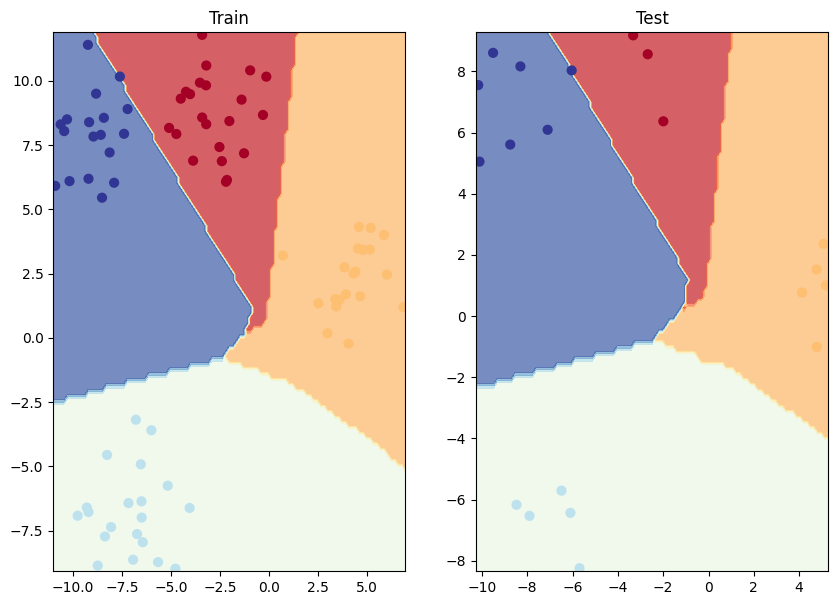

In [ ]:
#let's get visual
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_4,X_blob_test,y_blob_test)

It's possible to see that the data is linearly dividible. So, it's possible to divide the data with linear functions.

### 9. A few more classification metrics ... (to evaluate our model)

* Accuracy -out of 100 samples --> accuracy ratio? / good when you have balanced class  (tp+tn)/(tp+tn+fp+fn)   // Default metric for classification problems. Not the best for imbalanced class.
* Precision tp/(tp+fp) // Higher precision leads to less false positives
* Recall tp/(tp+fn) // Higher recall leads to less false negatives
* F1-score tp/(tp+fn) //
* Confusion matrix

Good article about precision and recall:
 https://willkoehrsen.github.io/statistics/learning/beyond-accuracy-precision-and-recall/


 Be aware of precision-recall rtade-off.

 - You can implement the metrics by your own, or use pytorch metrics: torch metrics.

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 5.8 MB/s eta 0:00:00


In [ ]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task='multiclass',num_classes=4)
torchmetrics_accuracy(y_pred,y_blob_test)

tensor(1.)